In [1]:
#https://github.com/HackerEarth-Challenges/machine-learning-challenge-1/blob/master/Yuvraj_Rank3_Python.ipynb

In [2]:
#Basic libraries
import numpy as np
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

#configure visualizations
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 15 , 8

#Train, test split and normalizing 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

#Cross Validation
from sklearn.model_selection import GridSearchCV

#Metric
from sklearn.metrics import roc_auc_score

import os, datetime as dt
import time

In [3]:
#ML algo functions
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier
import xgboost as xgb
from xgboost import XGBClassifier as xgc
seed = 19

In [4]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.precision', 3)

In [9]:
folder = r"G:\Study material\Data Science\Datasets\Loan_HackerEarth\\"
#r"/home/ws01/Documents/Datasets/Loan_HackerEarth"
#r"G:\Study material\Data Science\Datasets\Loan_HackerEarth\\"
train_file = "train_indessa.csv"
test_file = "test_indessa.csv"

In [10]:
def info(df,sort = True,save = "No"):
    size = df.shape[0]
    null = df.isnull().sum()
    nuni = df.nunique()
    dtype = df.dtypes
    missing_pct = null*100/size
    df_info  = pd.concat([dtype, missing_pct.round(2),nuni], axis=1, keys=['type','missing','nunique'])
    if sort == True:
        df_info.sort_values (['missing'],ascending=False,inplace=True)
    if (save == "Yes"):
        df_info.to_csv(os.path.join(folder,'info.csv'))
    return df_info

In [11]:
def create_cat(df,col,values):
    prefix = col
    unique_vals = values #list(df[col].unique())    
    dummies = pd.DataFrame()
    for val in unique_vals:
        dummies[prefix + "_" + val] = df[col] == val
        dummies[prefix + "_" + val] = dummies[prefix + "_" + val].apply(lambda x: 1 if x == True else 0)
            #le = LabelEncoder()
            #dummies[prefix + "_" + val] = le.fit_transform(dummies[prefix + "_" + val])
    #labelencode
    df = pd.concat([df,dummies],axis=1)
    return df 

In [12]:
#Data read
train = pd.read_csv(os.path.join(folder,train_file))

In [13]:
train.shape

(532428, 45)

In [14]:
train.head()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,batch_enrolled,int_rate,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,collections_12_mths_ex_med,mths_since_last_major_derog,application_type,verification_status_joint,last_week_pay,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,loan_status
0,58189336,14350,14350,14350.0,36 months,,19.19,E,E3,clerk,9 years,OWN,28700.0,Source Verified,n,NaN,debt_consolidation,Debt consolidation,349xx,FL,33.88,0.0,1.0,50.0,75.0,14.0,1.0,22515.0,73.1,28.0,f,1173.84,0.0,0.0,0.0,0.0,74.0,INDIVIDUAL,NaN,26th week,0.0,0.0,28699.0,30800.0,0
1,70011223,4800,4800,4800.0,36 months,BAT1586599,10.99,B,B4,Human Resources Specialist,< 1 year,MORTGAGE,65000.0,Source Verified,n,NaN,home_improvement,Home improvement,209xx,MD,3.64,0.0,1.0,NaN,NaN,6.0,0.0,7624.0,23.2,13.0,w,83.95,0.0,0.0,0.0,0.0,NaN,INDIVIDUAL,NaN,9th week,0.0,0.0,9974.0,32900.0,0
2,70255675,10000,10000,10000.0,36 months,BAT1586599,7.26,A,A4,Driver,2 years,OWN,45000.0,Not Verified,n,NaN,debt_consolidation,Debt consolidation,447xx,OH,18.42,0.0,0.0,NaN,NaN,5.0,0.0,10877.0,31.2,19.0,w,56.47,0.0,0.0,0.0,0.0,NaN,INDIVIDUAL,NaN,9th week,0.0,65.0,38295.0,34900.0,0
3,1893936,15000,15000,15000.0,36 months,BAT4808022,19.72,D,D5,Us office of Personnel Management,10+ years,RENT,105000.0,Not Verified,n,> My goal is to obtain a loan to pay off my high credit cards and get out of debt within 3 years.<br>,debt_consolidation,Debt consolidation,221xx,VA,14.97,0.0,2.0,46.0,NaN,10.0,0.0,13712.0,55.5,21.0,f,4858.62,0.0,0.0,0.0,0.0,NaN,INDIVIDUAL,NaN,135th week,0.0,0.0,55564.0,24700.0,0
4,7652106,16000,16000,16000.0,36 months,BAT2833642,10.64,B,B2,LAUSD-HOLLYWOOD HIGH SCHOOL,10+ years,RENT,52000.0,Verified,n,NaN,credit_card,refi,900xx,CA,20.16,0.0,0.0,NaN,NaN,11.0,0.0,35835.0,76.2,27.0,w,2296.41,0.0,0.0,0.0,0.0,NaN,INDIVIDUAL,NaN,96th week,0.0,0.0,47159.0,47033.0,0


In [15]:
id_col = train.pop('member_id')
target = train['loan_status']

In [16]:
weight = target.value_counts()[0]/target.value_counts()[1] #sum(positive cases) / sum(negative cases).

In [17]:
weight

3.2314288666184523

In [18]:
df_info = info(train,False)
df_info.T

,loan_amnt,funded_amnt,funded_amnt_inv,term,batch_enrolled,int_rate,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,collections_12_mths_ex_med,mths_since_last_major_derog,application_type,verification_status_joint,last_week_pay,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,loan_status
type,int64,int64,float64,object,object,float64,object,object,object,object,object,float64,object,object,object,object,object,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,float64,float64,float64,float64,float64,object,object,object,float64,float64,float64,float64,int64
missing,0,0,0,0,16,0,0,0,5.79,0,0,0,0,0,85.8,0,0.02,0,0,0,0,0,51.2,84.6,0,0,0,0.05,0,0,0,0,0,0,0.02,75,0,99.9,0,0,7.89,7.89,7.89,0
nunique,1370,1370,6442,2,104,535,7,35,190125,12,6,33988,3,2,70638,14,39693,917,51,4058,26,23,147,122,73,28,63459,1265,126,2,243149,4073,14024,12617,9,162,2,3,98,8,8081,251640,14697,2


In [19]:
target.value_counts(normalize=True)

0    0.764
1    0.236
Name: loan_status, dtype: float64

In [20]:
train.dtypes.value_counts()

float64    23
object     18
int64       3
dtype: int64

In [21]:
#funded_amnt: possible data leakage; drop
#funded_amnt_inv: may provide insights

In [22]:
train.term.unique() #binary

array(['36 months', '60 months'], dtype=object)

In [23]:
np.array((train.batch_enrolled.head(20))) #possible data leakage #drop

array([' ', 'BAT1586599', 'BAT1586599', 'BAT4808022', 'BAT2833642',
       'BAT2575549', ' ', nan, 'BAT4136152', 'BAT4694572', ' ', ' ',
       'BAT5924421', 'BAT3193689', 'BAT224923', 'BAT1184694', 'BAT1930365',
       ' ', 'BAT3873588', nan], dtype=object)

In [24]:
#subgrade is having info of grade; drop grade
#emp_title: too many unique values; drop

In [25]:
np.array(train.emp_title.head(20)) #High dimension; drop 

array(['clerk', 'Human Resources Specialist', 'Driver',
       'Us office of Personnel Management', 'LAUSD-HOLLYWOOD HIGH SCHOOL',
       'Design Consultant', 'TOYOTA OF NORTH HOLLYWOOD', 'Banker', 'LVN',
       'Registered Nurse', 'VP of Operations', 'Jp Morgan chase bank',
       'driver', 'Federal Law Enforcement', 'Truck Driver',
       'ASSISTANT QAPI COORDINATOR', 'LS1', nan, 'Production employee',
       'Principal Consultant'], dtype=object)

In [26]:
train.emp_length.unique() #extract num of years

array(['9 years', '< 1 year', '2 years', '10+ years', '5 years', '8 years',
       '7 years', '4 years', 'n/a', '1 year', '3 years', '6 years'], dtype=object)

In [27]:
train.home_ownership.unique()

array(['OWN', 'MORTGAGE', 'RENT', 'OTHER', 'NONE', 'ANY'], dtype=object)

In [28]:
train.home_ownership.value_counts() #create cat for RENT, OWN and anything else other than Mortgage, rent, own

MORTGAGE    265940
RENT        213668
OWN          52664
OTHER          117
NONE            36
ANY              3
Name: home_ownership, dtype: int64

In [29]:
train.verification_status.unique()

array(['Source Verified', 'Not Verified', 'Verified'], dtype=object)

In [30]:
#Plot categorical variables
def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target ,order=df[cat].unique())
    facet.add_legend()
    facet.set_xticklabels(rotation=30)
    plt.show()

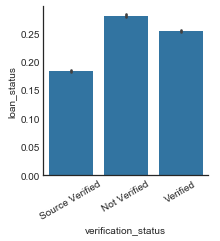

In [31]:
#plot loan status vs verfication status
plot_categories( train , 'verification_status' , 'loan_status')

In [32]:
train.pymnt_plan.unique()

array(['n', 'y'], dtype=object)

In [33]:
#desc High dimensional; drop

In [34]:
train.purpose.unique()

array(['debt_consolidation', 'home_improvement', 'credit_card', 'other',
       'major_purchase', 'small_business', 'vacation', 'car', 'moving',
       'medical', 'wedding', 'renewable_energy', 'house', 'educational'], dtype=object)

In [35]:
#title High dimensional
np.array(train.title.unique()[:20])

array(['Debt consolidation', 'Home improvement', 'refi',
       'Credit Card Debt Consolidation', 'PAY THEM OFF',
       'Credit card refinancing', 'Loan to payoff credit card debt',
       'Debt Consolidation', 'Close cards and consolidate', 'Other', nan,
       'Grateful Getting Out of Debt For Good', 'Credit Card Elimination',
       'Unexpected Expenses', 'consolidation loan', 'Major purchase',
       'Business funding', 'Business', 'credit card reconciliation',
       'Vacation'], dtype=object)

In [36]:
np.array(train.zip_code.head(20)) #zip code; create categories taking first 2 characters

array(['349xx', '209xx', '447xx', '221xx', '900xx', '461xx', '913xx',
       '351xx', '917xx', '427xx', '875xx', '926xx', '381xx', '773xx',
       '917xx', '922xx', '919xx', '191xx', '666xx', '606xx'], dtype=object)

In [37]:
np.array(train.addr_state.head(20)) # drop state as redundant info

array(['FL', 'MD', 'OH', 'VA', 'CA', 'IN', 'CA', 'AL', 'CA', 'KY', 'NM',
       'CA', 'TN', 'TX', 'CA', 'CA', 'CA', 'PA', 'KS', 'IL'], dtype=object)

In [38]:
train.mths_since_last_delinq.head()

0    50.0
1     NaN
2     NaN
3    46.0
4     NaN
Name: mths_since_last_delinq, dtype: float64

In [39]:
train.mths_since_last_delinq.isnull().sum()

272554

In [40]:
#mths_since_last_delinq, mths_since_last_record, mths_since_last_major_derog: replace NaN by 999

In [41]:
train.initial_list_status.value_counts()

f    274018
w    258410
Name: initial_list_status, dtype: int64

In [42]:
#last_week_pay: extract week number from it

In [43]:
test = pd.read_csv(os.path.join(folder,test_file))

In [44]:
test.set_index('member_id',inplace=True) #id col

In [45]:
df_info_test = info(test,False)
df_info_test.T

,loan_amnt,funded_amnt,funded_amnt_inv,term,batch_enrolled,int_rate,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,collections_12_mths_ex_med,mths_since_last_major_derog,application_type,verification_status_joint,last_week_pay,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
type,int64,int64,float64,object,object,float64,object,object,object,object,object,float64,object,object,object,object,object,object,object,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,object,float64,float64,float64,float64,float64,float64,object,object,object,float64,float64,float64,float64
missing,0,0,0,0,12.8,0,0,0,5.81,0,0,0,0,0,85.9,0,0.02,0,0,0,0,0,51.2,84.5,0,0,0,0.06,0,0,0,0,0,0,0.01,75,0,99.9,0,0,7.97,7.97,7.97
nunique,1365,1365,4840,2,104,533,7,35,135103,12,5,25034,3,2,47102,14,27976,904,51,4029,25,24,135,122,65,24,56301,1220,118,2,187736,2972,9673,8770,9,162,2,3,93,6,6610,196438,10841


## Data Description  
Total columns 43 + member id + target
Possible Leakage: Funded_amt, funded_amnt_inv

In [46]:
#Treating missing values
df_info[df_info['missing'] > 40]

,type,missing,nunique
desc,object,85.80,70638
mths_since_last_delinq,float64,51.19,147
mths_since_last_record,float64,84.58,122
mths_since_last_major_derog,float64,75.02,162
verification_status_joint,object,99.94,3


In [47]:
drop_missing = ['desc','verification_status_joint']#list(df_info[df_info['missing'] > 40].index) #Too high missing values

In [48]:
drop_missing

['desc', 'verification_status_joint']

In [49]:
train.drop(drop_missing, axis =1 , inplace = True)
test.drop(drop_missing, axis =1 , inplace = True)

In [50]:
drop_cols = ['funded_amnt','batch_enrolled','grade','emp_title','title','addr_state']

In [51]:
train.drop(drop_cols, axis =1 , inplace = True)
test.drop(drop_cols, axis =1 , inplace = True)

In [52]:
info(train,True).T

,mths_since_last_record,mths_since_last_major_derog,mths_since_last_delinq,total_rev_hi_lim,tot_cur_bal,tot_coll_amt,revol_util,collections_12_mths_ex_med,application_type,revol_bal,collection_recovery_fee,recoveries,total_rec_late_fee,total_rec_int,initial_list_status,last_week_pay,acc_now_delinq,total_acc,loan_amnt,pub_rec,funded_amnt_inv,open_acc,inq_last_6mths,delinq_2yrs,dti,zip_code,purpose,pymnt_plan,verification_status,annual_inc,home_ownership,emp_length,sub_grade,int_rate,term,loan_status
type,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,float64,float64,float64,float64,object,object,float64,float64,int64,float64,float64,float64,float64,float64,float64,object,object,object,object,float64,object,object,object,float64,object,int64
missing,84.6,75,51.2,7.89,7.89,7.89,0.05,0.02,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
nunique,122,162,147,14697,251640,8081,1265,9,2,63459,12617,14024,4073,243149,2,98,8,126,1370,28,6442,73,23,26,4058,917,14,2,3,33988,6,12,35,535,2,2


In [53]:
cat_col = train.dtypes[train.dtypes == "object"].index

In [54]:
#Fill NA by No_value
train[cat_col] = train[cat_col].fillna('missing')
test[cat_col] = test[cat_col].fillna('missing')

In [55]:
train.mths_since_last_delinq = train.mths_since_last_delinq.apply(lambda x: 999 if np.isnan(x) == True else x)
train.mths_since_last_record = train.mths_since_last_record.apply(lambda x: 999 if np.isnan(x) == True else x)
train.mths_since_last_major_derog = train.mths_since_last_major_derog.apply(lambda x: 999 if np.isnan(x) == True else x)

In [56]:
test.mths_since_last_delinq = test.mths_since_last_delinq.apply(lambda x: 999 if np.isnan(x) == True else x)
test.mths_since_last_record = test.mths_since_last_record.apply(lambda x: 999 if np.isnan(x) == True else x)
test.mths_since_last_major_derog = test.mths_since_last_major_derog.apply(lambda x: 999 if np.isnan(x) == True else x)

In [62]:
train['emp_length'].unique()

array(['9 years', '< 1 year', '2 years', '10+ years', '5 years', '8 years',
       '7 years', '4 years', 'n/a', '1 year', '3 years', '6 years'], dtype=object)

In [63]:
#emp_length
emp_len_dict = {'< 1 year' : 0, '1 year' : 1,'2 years' : 2, '3 years' : 3,'4 years' : 4, 
           '5 years' : 5, '6 years' : 6,'7 years' : 7, \
              '8 years' : 8, '9 years' : 9,'10+ years' :10, 'n/a':0} #'n/a':0

train['emp_length'] = train['emp_length'].apply(lambda x: emp_len_dict[x])  
test['emp_length'] = test['emp_length'].apply(lambda x: emp_len_dict[x])    

In [64]:
#home ownership
col = 'home_ownership'
dummies = pd.DataFrame()
dummies[col + "_" + 'MORTGAGE'] = train[col] == 'MORTGAGE'
dummies[col + "_" + 'MORTGAGE'] = dummies[col + "_" + 'MORTGAGE'].apply(lambda x: 1 if x == True else 0)
dummies[col + "_" + 'RENT'] = train[col] == 'RENT'
dummies[col + "_" + 'RENT'] = dummies[col + "_" + 'RENT'].apply(lambda x: 1 if x == True else 0)
dummies[col + "_" + 'OWN'] = train[col] == 'OWN'
dummies[col + "_" + 'OWN'] = dummies[col + "_" + 'OWN'].apply(lambda x: 1 if x == True else 0)

count = dummies.sum(axis=1)
dummies[col + "_" + 'Other'] = count == 0    
dummies[col + "_" + 'Other'] = dummies[col + "_" + 'Other'].apply(lambda x: 1 if x == True else 0)
dummies.drop(['home_ownership_MORTGAGE'],axis=1,inplace = True)
train.drop(['home_ownership'],axis=1,inplace = True)
train = pd.concat([train,dummies],axis=1)

In [65]:
dummies = pd.DataFrame()
dummies[col + "_" + 'MORTGAGE'] = test[col] == 'MORTGAGE'
dummies[col + "_" + 'MORTGAGE'] = dummies[col + "_" + 'MORTGAGE'].apply(lambda x: 1 if x == True else 0)
dummies[col + "_" + 'RENT'] = test[col] == 'RENT'
dummies[col + "_" + 'RENT'] = dummies[col + "_" + 'RENT'].apply(lambda x: 1 if x == True else 0)
dummies[col + "_" + 'OWN'] = test[col] == 'OWN'
dummies[col + "_" + 'OWN'] = dummies[col + "_" + 'OWN'].apply(lambda x: 1 if x == True else 0)

count = dummies.sum(axis=1)
dummies[col + "_" + 'Other'] = count == 0    
dummies[col + "_" + 'Other'] = dummies[col + "_" + 'Other'].apply(lambda x: 1 if x == True else 0)
dummies.drop(['home_ownership_MORTGAGE'],axis=1,inplace = True)
test.drop(['home_ownership'],axis=1,inplace = True)
test = pd.concat([test,dummies],axis=1)

In [66]:
#zip code
train['zip_code'] = train['zip_code'].apply(lambda x: x[:2])

In [67]:
test['zip_code'] = test['zip_code'].apply(lambda x: x[:2])

In [68]:
highest_cat = train['zip_code'].value_counts().index[0]
values_cat = [i for i in list(train.zip_code.unique()) if i not in [highest_cat]]

In [69]:
start = time.time()
train = create_cat(train,'zip_code',values_cat)
print("Time taken: ", time.time() - start)
train.drop('zip_code',axis=1, inplace=True)

Time taken:  23.392150402069092


In [70]:
test = create_cat(test,'zip_code',values_cat)
print("Time taken: ", time.time() - start)
test.drop('zip_code',axis=1, inplace=True)

Time taken:  39.64023804664612


In [71]:
import re

In [72]:
train['last_week_pay'] = train['last_week_pay'].apply(lambda x: '0th week' if x == 'NAth week' else x)
train['last_week_pay'] = train['last_week_pay'].apply(lambda x: int(re.findall(r'\d{1,4}',x)[0]))

In [73]:
test['last_week_pay'] = test['last_week_pay'].apply(lambda x: '0th week' if x == 'NAth week' else x)
test['last_week_pay'] = test['last_week_pay'].apply(lambda x: int(re.findall(r'\d{1,4}',x)[0]))

In [74]:
df_info = info(train,False)

In [75]:
df_info.T

,loan_amnt,funded_amnt_inv,term,int_rate,sub_grade,emp_length,annual_inc,verification_status,pymnt_plan,purpose,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,collections_12_mths_ex_med,mths_since_last_major_derog,application_type,last_week_pay,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,loan_status,home_ownership_RENT,home_ownership_OWN,home_ownership_Other,zip_code_34,zip_code_20,zip_code_44,zip_code_22,zip_code_90,zip_code_46,zip_code_91,zip_code_35,zip_code_42,zip_code_87,zip_code_92,zip_code_38,zip_code_77,zip_code_19,zip_code_66,zip_code_60,zip_code_32,zip_code_11,zip_code_63,zip_code_28,zip_code_76,zip_code_75,zip_code_07,zip_code_06,zip_code_95,zip_code_47,zip_code_17,zip_code_93,zip_code_12,zip_code_10,zip_code_16,zip_code_03,zip_code_49,zip_code_43,zip_code_08,zip_code_85,zip_code_30,zip_code_84,zip_code_74,zip_code_89,zip_code_55,zip_code_79,zip_code_27,zip_code_05,zip_code_01,zip_code_70,zip_code_94,zip_code_67,zip_code_98,zip_code_02,zip_code_23,zip_code_56,zip_code_62,zip_code_72,zip_code_41,zip_code_78,zip_code_37,zip_code_81,zip_code_25,zip_code_48,zip_code_40,zip_code_86,zip_code_96,zip_code_45,zip_code_21,zip_code_54,zip_code_36,zip_code_31,zip_code_18,zip_code_24,zip_code_64,zip_code_57,zip_code_68,zip_code_73,zip_code_88,zip_code_71,zip_code_82,zip_code_13,zip_code_29,zip_code_80,zip_code_53,zip_code_61,zip_code_99,zip_code_39,zip_code_15,zip_code_59,zip_code_69,zip_code_97,zip_code_04,zip_code_14,zip_code_65,zip_code_26,zip_code_83,zip_code_58,zip_code_51,zip_code_09,zip_code_50,zip_code_52,zip_code_00
type,int64,float64,object,float64,object,int64,float64,object,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,float64,float64,float64,float64,float64,object,int64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.05,0,0,0,0,0,0,0.02,0,0,0,0,7.89,7.89,7.89,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
nunique,1370,6442,2,535,35,11,33988,3,2,14,4058,26,23,148,123,73,28,63459,1265,126,2,243149,4073,14024,12617,9,163,2,97,8,8081,251640,14697,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2


In [76]:
num_missing = list(df_info[(df_info['missing'] > 0) & (df_info['type'] != 'object')].index)

In [77]:
num_missing

['revol_util',
 'collections_12_mths_ex_med',
 'tot_coll_amt',
 'tot_cur_bal',
 'total_rev_hi_lim']

In [78]:
for col in num_missing:
    avg = np.mean(train[col].dropna())
    print(col," : ",avg)
    train[col].fillna(avg,inplace=True)
    test[col].fillna(avg,inplace=True)

revol_util  :  55.0571891660288
collections_12_mths_ex_med  :  0.014299320162379564
tot_coll_amt  :  213.5622216694126
tot_cur_bal  :  139554.1107918862
total_rev_hi_lim  :  32080.572918535796


In [79]:
train.delinq_2yrs = train.delinq_2yrs.apply(lambda x: 0 if np.isnan(x) == True else x)
test.delinq_2yrs = test.delinq_2yrs.apply(lambda x: 0 if np.isnan(x) == True else x)

In [80]:
train.inq_last_6mths = train.inq_last_6mths.apply(lambda x: 0 if np.isnan(x) == True else x)
test.inq_last_6mths = test.inq_last_6mths.apply(lambda x: 0 if np.isnan(x) == True else x)

In [81]:
train.open_acc = train.open_acc.apply(lambda x: 0 if np.isnan(x) == True else x)
test.open_acc = test.open_acc.apply(lambda x: 0 if np.isnan(x) == True else x)

In [82]:
train.pub_rec = train.pub_rec.apply(lambda x: 0 if np.isnan(x) == True else x)
test.pub_rec = test.pub_rec.apply(lambda x: 0 if np.isnan(x) == True else x)

In [83]:
train.total_acc = train.total_acc.apply(lambda x: 0 if np.isnan(x) == True else x)
test.total_acc = test.total_acc.apply(lambda x: 0 if np.isnan(x) == True else x)

In [84]:
avg = np.mean(train['annual_inc'].dropna())
print('annual_inc'," : ",avg)
train.annual_inc = train.annual_inc.apply(lambda x: avg if np.isnan(x) == True else x)
test.annual_inc = test.annual_inc.apply(lambda x: avg if np.isnan(x) == True else x)

annual_inc  :  75029.84328906404


In [85]:
train.acc_now_delinq = train.acc_now_delinq.apply(lambda x: 0 if np.isnan(x) == True else x)
test.acc_now_delinq = test.acc_now_delinq.apply(lambda x: 0 if np.isnan(x) == True else x)

In [86]:
#Check status
train[train.isnull().any(axis=1)].shape

(0, 136)

In [87]:
test[test.isnull().any(axis=1)].shape

(0, 135)

### Data cleaned

In [ ]:
'''
#use chi square test to find correlated catgeorical features
from scipy.stats import chi2_contingency
df_cat = train[list(train.dtypes[train.dtypes == "object"].index)]
chi2, p_values =[], []
for i in range(len(df_cat.columns)):
    for j in range(len(df_cat.columns)):
        if j > i:
            chitest = chi2_contingency(pd.crosstab(df_cat[df_cat.columns[i]], df_cat[df_cat.columns[j]]))
            chi2.append(chitest[0])
            p_values.append(chitest[1])
        else:      # for same factor pair
            chi2.append(0)
            p_values.append(0)
            

Crosstab will create contingency table for the pair of features. 
Null hypothesis is that the features are independent of each other. 
If p value is less than significance value, i.e < 0.01 then we can reject Null hypothesis and
accept alternate hypothesis which stats that the features are related.
                     
chi2 = np.array(chi2).reshape((df_cat.shape[1],df_cat.shape[1])) # shape it as a matrix
chi2 = pd.DataFrame(chi2, index=df_cat.columns.values, columns=df_cat.columns.values)
p_values = np.array(p_values).reshape((df_cat.shape[1],df_cat.shape[1])) # shape it as a matrix
p_values = pd.DataFrame(p_values, index=df_cat.columns.values, columns=df_cat.columns.values)
chi2
'''

In [88]:
cat_col = list(train.dtypes[train.dtypes == "object"].index)

In [89]:
np.array(cat_col)

array(['term', 'sub_grade', 'verification_status', 'pymnt_plan', 'purpose',
       'initial_list_status', 'application_type'],
      dtype='<U19')

In [90]:
le = LabelEncoder()
bin_cols = []
for col in cat_col:
    if train[col].nunique() <= 2:
        bin_cols.append(col)
        le.fit(train[col])
        train[col] = le.transform(train[col])
        test[col] = le.transform(test[col])

print(bin_cols)

['term', 'pymnt_plan', 'initial_list_status', 'application_type']


In [91]:
#cols to create dummies for
[i for i in cat_col if i not in bin_cols]

['sub_grade', 'verification_status', 'purpose']

In [92]:
for col in ['sub_grade', 'verification_status', 'purpose']:
    highest_cat = train[col].value_counts().index[0]
    values_cat = [i for i in list(train[col].unique()) if i not in [highest_cat]]
    train = create_cat(train,col,values_cat)
    train.drop(col,axis=1, inplace=True)
    test = create_cat(test,col,values_cat)
    test.drop(col,axis=1, inplace=True)

In [93]:
#old method
'''
#drop one column from each categorical feature to solve multi collinearity issue
#Drop column with max value count
dummies_2_drop = []
dummies_col = []
for col in cat_col:
    if ((col not in bin_cols) and (col not in high_nunique_cols)):
        dummies_col.append(col)
        dummies_2_drop.append(col+"_"+train[col].value_counts().index[0])
dummies_list = pd.DataFrame()
dummies_list_test = pd.DataFrame()
for col in dummies_col:
    dummies_list = pd.concat([dummies_list,pd.get_dummies(train[col],prefix=col)],axis=1)
    dummies_list_test = pd.concat([dummies_list_test,pd.get_dummies(test[col],prefix=col)],axis=1)
train = pd.concat([train,dummies_list],axis=1)
test = pd.concat([test,dummies_list_test],axis=1)
train.drop(dummies_col,inplace=True,axis=1)
test.drop(dummies_col,inplace=True,axis=1)
train.drop(dummies_2_drop,inplace=True,axis=1)
test.drop(dummies_2_drop,inplace=True,axis=1)

'''

'\n#drop one column from each categorical feature to solve multi collinearity issue\n#Drop column with max value count\ndummies_2_drop = []\ndummies_col = []\nfor col in cat_col:\n    if ((col not in bin_cols) and (col not in high_nunique_cols)):\n        dummies_col.append(col)\n        dummies_2_drop.append(col+"_"+train[col].value_counts().index[0])\ndummies_list = pd.DataFrame()\ndummies_list_test = pd.DataFrame()\nfor col in dummies_col:\n    dummies_list = pd.concat([dummies_list,pd.get_dummies(train[col],prefix=col)],axis=1)\n    dummies_list_test = pd.concat([dummies_list_test,pd.get_dummies(test[col],prefix=col)],axis=1)\ntrain = pd.concat([train,dummies_list],axis=1)\ntest = pd.concat([test,dummies_list_test],axis=1)\ntrain.drop(dummies_col,inplace=True,axis=1)\ntest.drop(dummies_col,inplace=True,axis=1)\ntrain.drop(dummies_2_drop,inplace=True,axis=1)\ntest.drop(dummies_2_drop,inplace=True,axis=1)\n\n'

In [94]:
not_in_test = []
for col in train.columns:
    if col not in test.columns:
        not_in_test.append(col)
print("Not in test",not_in_test)
not_in_train = []
for col in test.columns:
    if col not in train.columns:
        not_in_train.append(col)
print("Not in train",not_in_train)

Not in test ['loan_status']
Not in train []


In [95]:
#align train and test
#train, test = train.align(test, join = 'inner', axis = 1)

print('Training Features shape: ', train.shape)
print('Testing Features shape: ', test.shape)

Training Features shape:  (532428, 182)
Testing Features shape:  (354951, 181)


In [96]:
train[train.isnull().any(axis=1)].shape

(0, 182)

In [97]:
test[test.isnull().any(axis=1)].shape

(0, 181)

In [ ]:
'''
scaler = StandardScaler()
df_scaled = scaler.fit_transform(train)
corr = pd.DataFrame(df_scaled,columns=list(train.columns)).corr()
sns.set(font_scale = 6)
plt.subplots( figsize =( 100 , 80 ) )
sns_plot = sns.heatmap(corr,cmap = sns.diverging_palette( 10 , 150 , as_cmap = True ))
sns_plot.figure.savefig(os.path.join(folder,'sigma_cleaned_corr' + '.png'))
plt.show()
'''
#Drop correlated features

In [ ]:
'''
grade_dict = {'A': 1, 'B': 2, 'C':3, 'D':4,'E':5,'F':6,'G':7}
train['grade_new'] = train['grade'].apply(lambda x: grade_dict[x])
train['sub_grade_new'] = train['sub_grade'].apply(lambda x: int(str(grade_dict[x[0]])+x[1]))
'''

In [ ]:
train.dtypes.value_counts()

In [ ]:
test.dtypes.value_counts()

In [ ]:
train.dropna(inplace=True)

In [ ]:
train.shape

In [98]:
target = train.pop('loan_status')
#done till here

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
# scikit-learn transformer class that can be used to remove columns that have a high VIF factor 
from statsmodels.stats.outliers_influence import variance_inflation_factor

class ReduceVIF(BaseEstimator, TransformerMixin):
    def __init__(self, thresh=5.0, impute=True, impute_strategy='median'):
        # From looking at documentation, values between 5 and 10 are "okay".
        # Above 10 is too high and so should be removed.
        self.thresh = thresh
        
        # The statsmodel function will fail with NaN values, as such we have to impute them.
        # By default we impute using the median value.
        # This imputation could be taken out and added as part of an sklearn Pipeline.
        if impute:
            self.imputer = Imputer(strategy=impute_strategy)

    def fit(self, X, y=None):
        print('ReduceVIF fit')
        if hasattr(self, 'imputer'):
            self.imputer.fit(X)
        return self

    def transform(self, X, y=None):
        print('ReduceVIF transform')
        columns = X.columns.tolist()
        if hasattr(self, 'imputer'):
            X = pd.DataFrame(self.imputer.transform(X), columns=columns)
        return ReduceVIF.calculate_vif(X, self.thresh)

    @staticmethod
    def calculate_vif(X, thresh=5.0):
        # Taken from https://stats.stackexchange.com/a/253620/53565 and modified
        dropped=True
        while dropped:
            variables = X.columns
            dropped = False
            vif = [variance_inflation_factor(X[variables].values, X.columns.get_loc(var)) for var in X.columns]
            
            max_vif = max(vif)
            if max_vif > thresh:
                maxloc = vif.index(max_vif)
                print(f'Dropping {X.columns[maxloc]} with vif={max_vif}')
                X = X.drop([X.columns.tolist()[maxloc]], axis=1)
                dropped=True
        return X

In [ ]:
'''
transformer = ReduceVIF()
X = transformer.fit_transform(train, target) #[X.columns[-10:]]
X
'''

In [99]:
X_train, X_test, y_train, y_test = train_test_split(train, target, random_state=seed)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_pred = scaler.transform(test)

In [100]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(399321, 181) (133107, 181) (399321,) (133107,)


In [91]:
classifier = xgb.sklearn.XGBClassifier(nthread=-1, seed=42,colsample_bylevel=0.8,
                                       colsample_bytree=0.8,random_state=seed,min_child_weight=1)
classifier.fit(X_train_scaled, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=-1, objective='binary:logistic', random_state=19,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=1)

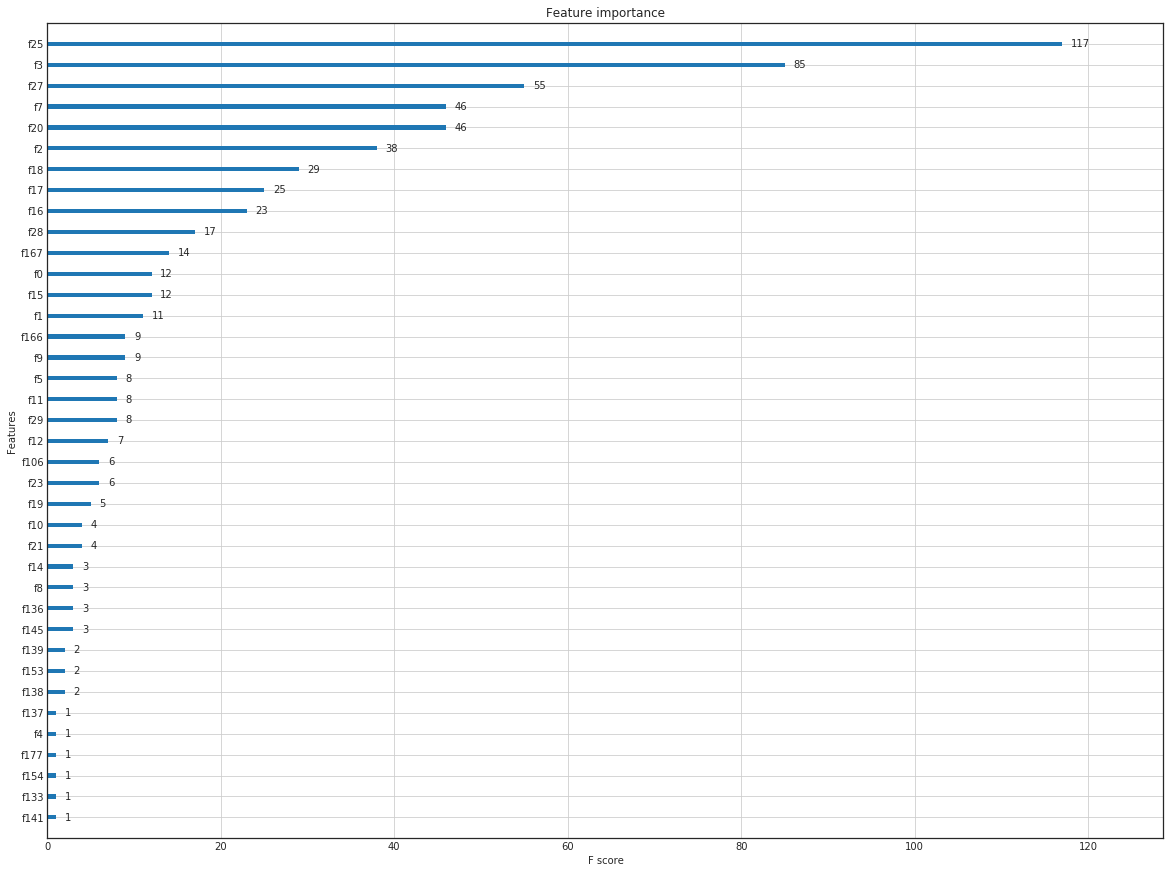

In [92]:
plt.figure(figsize=(20,15))
xgb.plot_importance(classifier, ax=plt.gca())
plt.show()

In [103]:
model = xgb.sklearn.XGBClassifier(n_jobs=-1,seed=42,max_depth = 6, colsample_bylevel=0.9,
                                       colsample_bytree=0.9,base_score = 0.6, random_state=seed,min_child_weight=1)
eval_set = [(X_test_scaled, y_test)]
model.fit(X_train_scaled, y_train, early_stopping_rounds=10, eval_metric="auc", eval_set=eval_set, verbose=True)
# make predictions for test data
y_pred = model.predict(X_test_scaled)
#predictions = [round(value) for value in y_pred]


[0]	validation_0-auc:0.756149
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.775064
[2]	validation_0-auc:0.781589
[3]	validation_0-auc:0.793018
[4]	validation_0-auc:0.798635
[5]	validation_0-auc:0.800981
[6]	validation_0-auc:0.801506
[7]	validation_0-auc:0.804551
[8]	validation_0-auc:0.806172
[9]	validation_0-auc:0.806061
[10]	validation_0-auc:0.806112
[11]	validation_0-auc:0.806109
[12]	validation_0-auc:0.809196
[13]	validation_0-auc:0.810357
[14]	validation_0-auc:0.811028
[15]	validation_0-auc:0.812886
[16]	validation_0-auc:0.813472
[17]	validation_0-auc:0.813059
[18]	validation_0-auc:0.813754
[19]	validation_0-auc:0.81373
[20]	validation_0-auc:0.815376
[21]	validation_0-auc:0.815455
[22]	validation_0-auc:0.815543
[23]	validation_0-auc:0.817012
[24]	validation_0-auc:0.82316
[25]	validation_0-auc:0.823449
[26]	validation_0-auc:0.825122
[27]	validation_0-auc:0.828775
[28]	validation_0-auc:0.829412
[29]	validation_0-auc:0.830501
[30]	validation_0-

/home/ws01/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [104]:
# evaluate predictions
accuracy = roc_auc_score(y_test, y_pred)
print("ROC AUC score: %.2f%%" % (accuracy * 100.0))

ROC AUC score: 71.96%


In [112]:
imps = pd.DataFrame(model.feature_importances_,index = train.columns)

In [ ]:
for i,k in zip(train.columns,model.feature_importances_):
    print(i,": ", k)

In [123]:
imp_cols = list(imps.sort_values(by = 0,ascending=False)[:52].index)

In [ ]:
model = xgb.sklearn.XGBClassifier(n_jobs=-1,seed=42,max_depth = 6, colsample_bylevel=0.9,
                                       colsample_bytree=0.9,base_score = 0.6, random_state=seed,min_child_weight=1)

In [126]:
param_test1 = {'max_depth':[i for i in range(5,11,2)]}

In [129]:
from sklearn.model_selection import StratifiedKFold

In [132]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
grid_search1 = GridSearchCV(model, param_grid = param_test1, scoring="roc_auc", n_jobs=-1, cv=kfold, verbose=1)
result = grid_search1.fit(X_train_scaled,y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 28.4min finished


In [134]:
grid_search1.best_params_

{'max_depth': 9}

In [136]:
grid_search1.best_score_

0.9297057862169886

In [137]:
model = xgb.sklearn.XGBClassifier(n_jobs=-1,seed=42,max_depth = 9, colsample_bylevel=0.9,
                                       colsample_bytree=0.9,random_state=seed,min_child_weight=1)

In [138]:
param_test2 = {'base_score':[i/10. for i in range(5,10)]}

In [139]:
grid_search2 = GridSearchCV(model, param_grid = param_test2, scoring="roc_auc", n_jobs=-1, cv=kfold, verbose=3)
result2 = grid_search2.fit(X_train_scaled,y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] base_score=0.5 ..................................................
[CV] base_score=0.5 ..................................................
[CV] base_score=0.5 ..................................................
[CV] base_score=0.5 ..................................................
[CV] base_score=0.5 ..................................................
[CV] base_score=0.6 ..................................................
[CV] base_score=0.6 ..................................................
[CV] base_score=0.6 ..................................................
[CV] ......... base_score=0.5, score=0.9294625493667148, total=19.6min
[CV] .......... base_score=0.5, score=0.927555284428746, total=19.4min
[CV] ......... base_score=0.6, score=0.9311032864174096, total=19.5min
[CV] ......... base_score=0.5, score=0.9323704436653155, total=19.2min
[CV] ......... base_score=0.6, score=0.9282881344946071, total=19.5min
[CV] ......... ba

[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed: 59.9min remaining: 18.9min


[CV] ......... base_score=0.8, score=0.9277776666403327, total=19.6min
[CV] ......... base_score=0.9, score=0.9305168707194362, total=19.5min
[CV] ......... base_score=0.9, score=0.9293485614593002, total=19.6min
[CV] ......... base_score=0.9, score=0.9292766547390627, total=19.6min
[CV] ......... base_score=0.9, score=0.9307987631922343, total=19.7min
[CV] .......... base_score=0.9, score=0.927457636856038, total= 8.9min


[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 61.3min finished


In [140]:
grid_search2.best_params_

{'base_score': 0.8}

In [141]:
grid_search2.best_score_

0.9301035343405016

In [142]:
model = xgb.sklearn.XGBClassifier(n_jobs=-1,seed=42,max_depth = 9, colsample_bylevel=1,
                                       colsample_bytree=1,base_score = 0.8,random_state=seed)

In [143]:
param_test3 = {'min_child_weight':[i for i in range(1,7,2)]}

In [144]:
grid_search3 = GridSearchCV(model, param_grid = param_test3, scoring="roc_auc", n_jobs=-1, cv=kfold, verbose=3)
result3 = grid_search3.fit(X_train_scaled,y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] min_child_weight=1 ..............................................
[CV] min_child_weight=1 ..............................................
[CV] min_child_weight=1 ..............................................
[CV] min_child_weight=1 ..............................................
[CV] min_child_weight=1 ..............................................
[CV] min_child_weight=3 ..............................................
[CV] min_child_weight=3 ..............................................
[CV] min_child_weight=3 ..............................................
[CV] ..... min_child_weight=1, score=0.9274169324014636, total=23.5min
[CV] min_child_weight=3 ..............................................
[CV] ..... min_child_weight=1, score=0.9280994181775728, total=23.7min
[CV] ..... min_child_weight=3, score=0.9290806464843104, total=23.6min
[CV] ..... min_child_weight=1, score=0.9282777112044733, total=23.8min
[CV] ..... min_ch

[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed: 24.1min remaining: 36.1min


[CV] ..... min_child_weight=1, score=0.9258849453528637, total=23.9min
[CV] min_child_weight=3 ..............................................
[CV] min_child_weight=5 ..............................................
[CV] min_child_weight=5 ..............................................
[CV] min_child_weight=5 ..............................................
[CV] min_child_weight=5 ..............................................
[CV] min_child_weight=5 ..............................................
[CV] ..... min_child_weight=3, score=0.9290886918391839, total=16.2min
[CV] ..... min_child_weight=5, score=0.9269576625686784, total=19.3min
[CV] ...... min_child_weight=3, score=0.927580839810983, total=19.3min
[CV] ..... min_child_weight=5, score=0.9289835973545048, total=19.4min


[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed: 44.2min remaining: 11.0min


[CV] ..... min_child_weight=5, score=0.9273645769735034, total=19.4min
[CV] ..... min_child_weight=5, score=0.9290168063305282, total=19.4min
[CV] ...... min_child_weight=5, score=0.925439452303933, total=19.4min


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 44.2min finished


In [145]:
grid_search3.best_params_

{'min_child_weight': 3}

In [146]:
grid_search3.best_score_

0.9284630858138065

In [149]:
model = xgb.sklearn.XGBClassifier(n_jobs=-1,seed=42,max_depth = 9, colsample_bylevel=0.9,
                                       colsample_bytree=0.9,base_score = 0.8,random_state=seed,min_child_weight=3)

In [150]:
param_test4 = {'n_estimators':[100 + i for i in range(10,70,10)]}

In [151]:
grid_search4 = GridSearchCV(model, param_grid = param_test4, scoring="roc_auc", n_jobs=-1, cv=kfold, verbose=3)
result4 = grid_search4.fit(X_train_scaled,y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] n_estimators=110 ................................................
[CV] n_estimators=110 ................................................
[CV] n_estimators=110 ................................................
[CV] n_estimators=110 ................................................
[CV] n_estimators=110 ................................................
[CV] n_estimators=120 ................................................
[CV] n_estimators=120 ................................................
[CV] n_estimators=120 ................................................
[CV] ........ n_estimators=110, score=0.930334907013185, total=20.9min
[CV] n_estimators=120 ................................................
[CV] ....... n_estimators=110, score=0.9328976131460095, total=21.0min
[CV] ....... n_estimators=110, score=0.9342886357962072, total=21.1min
[CV] ....... n_estimators=110, score=0.9312471994341457, total=21.1min
[CV] n_estimators

[Parallel(n_jobs=-1)]: Done  26 out of  30 | elapsed: 95.2min remaining: 14.6min


[CV] ....... n_estimators=160, score=0.9393888628778695, total=22.2min
[CV] ....... n_estimators=160, score=0.9377865138263644, total=22.1min
[CV] ....... n_estimators=160, score=0.9405395059171736, total=20.7min
[CV] ....... n_estimators=160, score=0.9374512941715547, total=19.3min


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 96.6min finished


In [152]:
grid_search4.best_params_,grid_search4.best_score_

({'n_estimators': 160}, 0.9386129281212906)

In [ ]:
y_pred = model.predict(X_test_scaled)

In [101]:
model = xgb.sklearn.XGBClassifier(n_jobs=-1,seed=42,max_depth = 9, colsample_bylevel=0.9,
                                       colsample_bytree=0.9,base_score = 0.8,
                                  random_state=seed,min_child_weight=3,n_estimators = 160)
eval_set = [(X_test_scaled, y_test)]
model.fit(X_train_scaled, y_train, early_stopping_rounds=10, eval_metric="auc", eval_set=eval_set, verbose=True)
# make predictions for test data
#y_pred = model.predict(X_test_scaled)
#predictions = [round(value) for value in y_pred]
y_pred = model.predict(X_pred)

[0]	validation_0-auc:0.777728
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.793486
[2]	validation_0-auc:0.811161
[3]	validation_0-auc:0.819923
[4]	validation_0-auc:0.827965
[5]	validation_0-auc:0.833716
[6]	validation_0-auc:0.83759
[7]	validation_0-auc:0.839229
[8]	validation_0-auc:0.840783
[9]	validation_0-auc:0.845247
[10]	validation_0-auc:0.847766
[11]	validation_0-auc:0.847737
[12]	validation_0-auc:0.848994
[13]	validation_0-auc:0.850583
[14]	validation_0-auc:0.851811
[15]	validation_0-auc:0.853548
[16]	validation_0-auc:0.85511
[17]	validation_0-auc:0.8573
[18]	validation_0-auc:0.858826
[19]	validation_0-auc:0.859172
[20]	validation_0-auc:0.860453
[21]	validation_0-auc:0.862757
[22]	validation_0-auc:0.863456
[23]	validation_0-auc:0.863638
[24]	validation_0-auc:0.863932
[25]	validation_0-auc:0.86411
[26]	validation_0-auc:0.864775
[27]	validation_0-auc:0.866249
[28]	validation_0-auc:0.869084
[29]	validation_0-auc:0.871975
[30]	validation_0-auc

In [102]:
preds = model.predict_proba(X_pred)[:,1]

In [103]:
sub = pd.DataFrame({'member_id':test.index, 'loan_status':preds})

In [106]:
sub = sub[['member_id','loan_status']]

In [107]:
sub.to_csv(os.path.join(folder,'submission.csv'), index=False)

In [148]:
# evaluate predictions
accuracy = roc_auc_score(y_test, y_pred)
print("ROC AUC score: %.2f%%" % (accuracy * 100.0))

ROC AUC score: 80.33%


In [94]:
y_test.value_counts(normalize=True)

0    0.763
1    0.237
Name: loan_status, dtype: float64

In [95]:
#Baseline model
from sklearn.metrics import roc_auc_score

# Get predictions on the test set
baseline_predictions = np.zeros(y_test.shape)

# Compute MAE
baseline = roc_auc_score(y_test, baseline_predictions)

print("Baseline score is {:.2f}".format(baseline))

Baseline score is 0.50
